## Seefood

This replicates the "hotdog"/"not hotdog" joke from the Silicon Valley series.

Dataset on Kaggle: https://www.kaggle.com/datasets/dansbecker/hot-dog-not-hot-dog

In [1]:
from fastai.vision.all import *
import torchvision.transforms as transforms

In [7]:
path = untar_data("https://algorithmicgaze.s3.amazonaws.com/projects/2024-onnx-experiments/datasets/not-hot-dog.zip")/"not-hot-dog"

In [8]:
# Total amount of files
files = get_image_files(path)
len(files)

998

In [9]:
# The labels are the folders, so "hotdog" and "not_hotdog"
path.ls()

(#3) [Path('/Users/fdb/.fastai/data/not-hot-dog/not-hot-dog/.DS_Store'),Path('/Users/fdb/.fastai/data/not-hot-dog/not-hot-dog/test'),Path('/Users/fdb/.fastai/data/not-hot-dog/not-hot-dog/train')]

In [10]:
item_tfms = Resize(384, method='crop')
dls = ImageDataLoaders.from_folder(path, train="train", valid_pct=0.8, item_tfms=item_tfms)

In [11]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 384, 384]), torch.Size([64]))

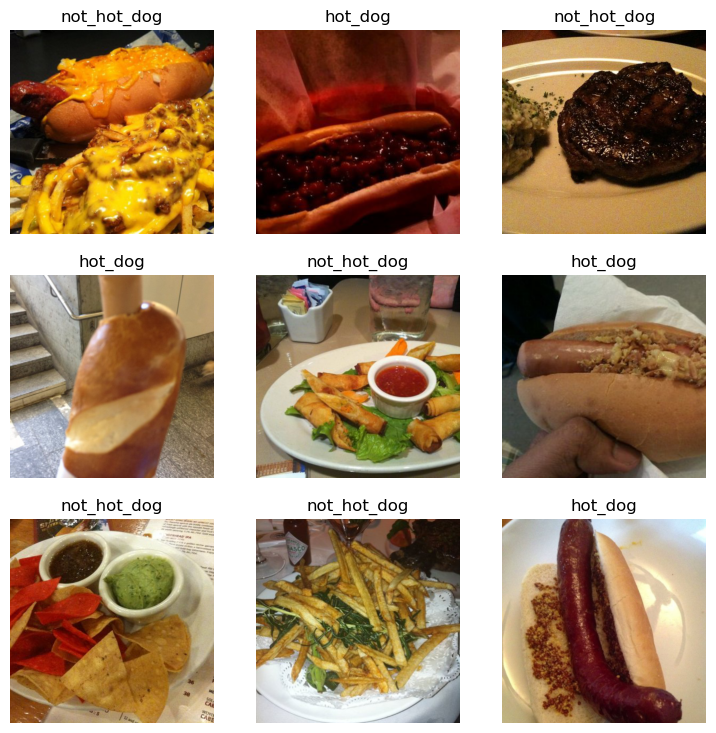

In [12]:
dls.show_batch()

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.188813,0.566281,0.266917,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.518577,0.408576,0.181704,00:07


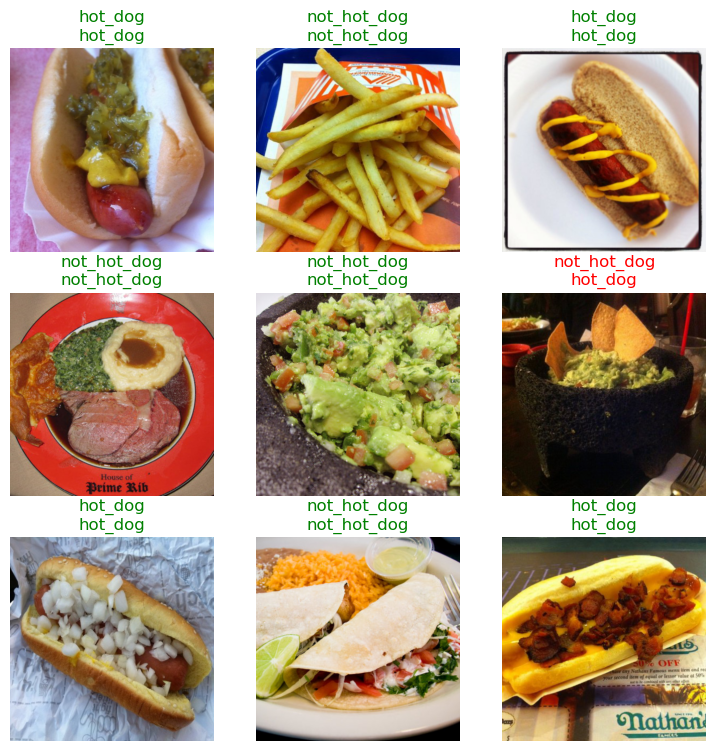

In [14]:
learn.show_results()

In [15]:
learn.predict("hot_dog_1.jpg")

('hot_dog', tensor(0), tensor([0.9299, 0.0701]))

In [16]:
learn.predict("not_hot_dog_1.jpg")

('not_hot_dog', tensor(1), tensor([0.4989, 0.5011]))

In [17]:
# The exported model is stored in a weird location.
learn.export("not-hot-dog.pkl")
learn.path

Path('/Users/fdb/.fastai/data/not-hot-dog/not-hot-dog')

# Export to ONNX

I want to use this model in ONNX, so let's export it. 

Kudos to Tomas for this post: https://dev.to/tkeyo/export-fastai-resnet-models-to-onnx-2gj7


In [18]:
pytorch_model = learn.model.to("cpu").eval()

In [19]:
# Define a softmax layer. This will turn the inference results into values that are scaled between 0-1.
softmax_layer = torch.nn.Softmax(dim=1)

In [20]:
# Define a normalization layer. These use the mean and standard deviations values as
# recommended by ImageNet: https://pytorch.org/vision/stable/models.html
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [21]:
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

In [22]:
# Export the model to ONNX
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 384, 384), 
    "not-hot-dog.onnx", 
    do_constant_folding=True,
    export_params=True,
    input_names=["image_1_3_384_384"],
    output_names=["hot_dog"],
    opset_version=11
)